In [1]:
import pickle
import numpy as np
import PIL.Image
import itertools
from IPython.core.display import Image, display
import scipy.ndimage
import random
import numpy as np
import matplotlib.pylab as plt
import tqdm
import math
%matplotlib inline

np.random.seed(42)

# Загружаем датасет

In [2]:
with open('./hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('./hw_1_test_no_lables.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)

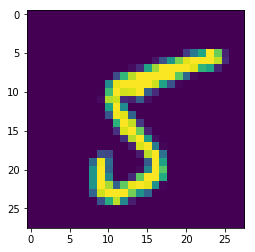

In [3]:
# Пример, как можно визуализировать данные
plt.imshow(train['data'][0].reshape(28,28))

# Перпроцессинг

In [4]:
X_train, y_train = train['data'], train['labels']
X_test = test_no_lables['data']

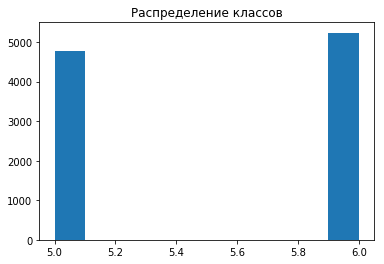

In [5]:
plt.title('Распределение классов')
_ = plt.hist(y_train)

Преобразуем y в множество ${-1, 1}$

In [6]:
encode_rule = {5: -1, 6: 1}

In [7]:
for k in encode_rule:
    y_train[y_train == k] = encode_rule[k]

In [8]:
np.unique(y_train)

array([-1.,  1.])

In [9]:
X_train, X_test = X_train/255., X_test/255.

In [10]:
X_train = np.hstack([X_train, np.ones((len(X_train), 1))])
X_test = np.hstack([X_test, np.ones((len(X_test), 1))])

# Обучаем модель

Функция потерь 
$$
\large L(\vec{x},\vec{y},\vec{w}) = \sum_{i=1}^{\ell} \log (1 + \exp^{-y_i\vec{w}^T\vec{x_i}})
$$
Градиент функции потерь:
$$
    \nabla L = \left\{ - \frac{y_i \vec{x_i} }  { 1 + \exp^{y_i\vec{w}^T\vec{x_i}} } + \lambda \vec{w} \right\} 
$$

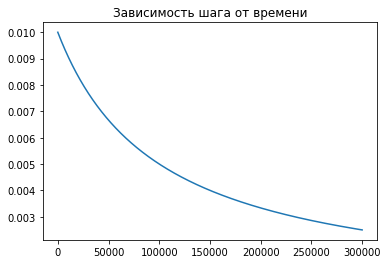

In [11]:
def learning_rate(it):
    return 1 / (1e2 + it / len(X_train)*10)

plt.title('Зависимость шага от времени')
plt.plot(np.arange(len(X_train)*30), learning_rate(np.arange(len(X_train)*30)))

In [12]:
import inspect

In [13]:
class LogisticReg:
    
    def __init__(self, lr=1e-3, nepochs=30, l2_reg=1e-2):
        self.lr = lr
        self.nepochs = nepochs
        self.l2_reg = l2_reg
        
    def _loss(self, X, y, w):
        return np.sum(np.log(1 + np.exp(-y*(X@w)))) / len(X) + self.l2_reg * np.sum(w**2)
    
    def _loss_grad(self, X, y, w):
        return  - np.sum((y[:, np.newaxis] * X) / (1 + np.exp(y*(X@w)))[:, np.newaxis], axis=0)/len(X)  + 2*self.l2_reg*w 
    
    def fit(self, X, y, w=None, callback=None):
        if w is None:
            self.w = np.random.randn(X.shape[1])
        elif len(w) != X.shape[1]:
            raise ValueError("Invalid w")
        else:
            self.w = w
        
        prev_grad = None
        global_iter = 0
        for epoch in range(self.nepochs):
            indxs = np.arange(len(X))
            np.random.shuffle(indxs)
            for i in indxs:
            
                err_i = self._loss(X[[i]], y[[i]], self.w)
                grad = self._loss_grad(X[[i]], y[[i]], self.w)
                
                prev_grad = grad
                
                # lr reduction
                if inspect.isfunction(self.lr):
                    lr = self.lr(global_iter)
                elif isinstance(self.lr, float) or isinstance(self.lr, int):
                    lr = float(self.lr)
                else:
                    raise  ValueError('Invalid lr')
                    
                global_iter += 1

                self.w -= grad * lr
                
            if callback:
                callback(self, epoch)
    
    def predict_proba(self, X):
        return 1 / (1 + np.exp(-X @ self.w))
    
    def predict(self, X, thres=.5):
        pred = self.predict_proba(X)
        pred[pred > thres] = 1
        pred[pred <= thres] = -1
        return pred

In [14]:
def test_grad(m, h=1e-6):
    X = np.random.randn(10, 2)
    y = np.random.randint(2, size=10)*2 - 1
    w = np.random.randn(2)
    
    comp_grad = np.zeros_like(w)
    for i in range(comp_grad.size):
        _h = np.zeros_like(w)
        _h[i] = h
        comp_grad[i] = (m._loss(X, y, w+_h) - m._loss(X, y, w-_h)) / (2*h)
    
    return np.allclose(m._loss_grad(X, y, w), comp_grad, h)

In [15]:
test_grad(LogisticReg())

True

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, accuracy_score

In [17]:
class Callback:
    
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.X_train = X_train
        self.y_train = y_train
        self.train_log_loss = []
        self.test_log_loss = []
        self.train_acc = []
        self.test_acc = []
        self.epochs = []
    
    def __call__(self, model, epoch):
        self.epochs.append(epoch)
        
        pred_proba_test = model.predict_proba(self.X_test)
        pred_proba_train = model.predict_proba(self.X_train)
        self.train_log_loss.append(log_loss(self.y_train, pred_proba_train))
        self.test_log_loss.append(log_loss(self.y_test, pred_proba_test))
        
        pred_test = model.predict(self.X_test)
        pred_train = model.predict(self.X_train)
        self.train_acc.append(accuracy_score(self.y_train, pred_train))
        self.test_acc.append(accuracy_score(self.y_test, pred_test))
        
    def summary_plot(self):
        print('Final log loss: ')
        print('\t train: ', self.train_log_loss[-1])
        print('\t  test: ', self.test_log_loss[-1])
        print('Final accuracy: ')
        print('\t train: ', self.train_acc[-1])
        print('\t  test: ', self.test_acc[-1])
        
        plt.figure(figsize=(12, 4))

        plt.subplot(121)
        plt.title('Log loss')
        plt.semilogy(self.epochs, self.test_log_loss, label='test')
        plt.semilogy(self.epochs, self.train_log_loss, label='train')
        plt.legend()

        plt.subplot(122)
        plt.title('Accuracy')
        plt.semilogy(self.epochs, self.test_acc, label='test')
        plt.semilogy(self.epochs, self.train_acc, label='train')
        plt.legend()
        
        plt.show()
        

In [18]:
from sklearn.linear_model import LogisticRegressionCV

In [19]:
clf = LogisticRegressionCV(5).fit(X_train, y_train)

c:\users\artyom tsanda\onedrive - phystech.edu\курсы\технотрек\базовый курс по нейронным сетям\env\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\artyom tsanda\onedrive - phystech.edu\курсы\технотрек\базовый курс по нейронным сетям\env\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\artyom tsanda\onedrive - phystech.edu\курсы\технотрек\базовый курс по нейронным сетям\env\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\artyom tsanda\onedrive - phystech.edu\курсы\технотрек\базовый курс по нейронным сетям\en

In [20]:
y_pred = clf.predict_proba(X_train)

In [21]:
log_loss(y_train, y_pred)

0.030394247383224358

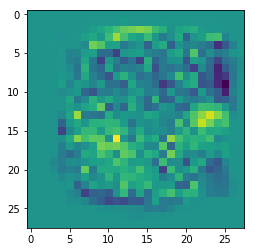

In [27]:
plt.imshow(clf.coef_[:, :-1].reshape(28,28))

In [30]:
clf.intercept_

array([-2.82786223])

In [32]:
clf.C_

array([1.])

In [ ]:
kf = KFold(n_splits=5)
clbks = []

parameters = {
    'nepochs': 100, 
    'lr': 0.01, 
    'l2_reg': 1e-2
}

for epoch, (train_index, test_index) in tqdm.tqdm_notebook(enumerate(kf.split(X_train)), total=kf.get_n_splits()):
    lr = LogisticReg(**parameters)
    clbk = Callback(X_train[train_index], y_train[train_index], X_train[test_index], y_train[test_index])
    lr.fit(X_train[train_index], y_train[train_index], callback=clbk)
    print('FOLD #', epoch)
    clbk.summary_plot()
    clbks.append(clbk)

In [18]:
lr = LogisticReg(**parameters)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

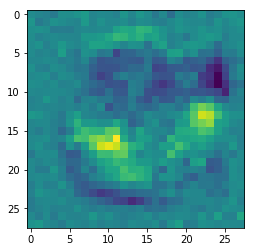

In [19]:
plt.imshow(lr.w.reshape(28,28))

# Оцениваем результат

Обязательно отрисуйте 2 графика:
- loss на обучающем и тестовом множесте
- % правильно классифицированных примеров на тестовом и обучающем множестве

Отрисовал во время обучения

# Сохраняем данные для кагла

https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528

Результат записывается в простой текстовый файл. Первая строчка "Id,Prediction", далее для каждого примера из валидационного множества записывается его Id (порядковый номер, с нуля) и вероятность принадлежности к классу '6', например '123,0.12'.

Важно соблюдать тот же порядок следования элементов, что и в наборе данных. Нумерация id с 0

In [20]:
#X = test_no_lables['data']
Y_pred = lr.predict_proba(X_test)

with open('solution.csv', 'w') as fout:
    print("Id,Prediction", file=fout)
    for i in range(len(X_test)):
        print(i, Y_pred[i], sep=',', file=fout)

# Сдача

1. Регистрируетесь на конкурс https://www.kaggle.com/t/34e77301ef914c5792e4f4306144a6b3 
1. Преодолеваете "Pass level" baseline
1. После того, как вы преодолеете baseline, присылайте ноутбук с решение по адресу **voropaev@corp.mail.ru**

# Внимание
- Тему письма писать в формате "[МФТИ][1] Фамилия"
- Внутри писма прикрепляете файл ноутбука с именем <ваша фамилия>.ipynb